# Pooled screening strategy modelling

A simple simulation to explore basic relationships between batch size, prevalence, efficiency, etc.

In [1]:
import json
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

np.random.seed(seed=1)

In [2]:
def unit_pcr(is_infected: bool, sens: float, spec: float) -> bool:
    '''
    Perform simple pcr on individual sample.
    '''
    if is_infected:
        r = np.random.binomial(n=1, p=sens)
        return r
    
    else:
        r = np.random.binomial(n=1, p=1-spec)
        return r
    
    
def pooled_pcr(batch: np.array, sens: float, spec: float) -> bool:
    '''
    Returns 1 if pooled pcr positive.
    '''
    is_batch_infected = (batch.sum() > 0)
    
    if is_batch_infected:
        r = np.random.binomial(n=1, p=sens)
        return r
    
    else:
        r = np.random.binomial(n=1, p=1-spec)
        return r

    
def rapid_screening(batch: np.array, sens: float, spec: float) -> np.array:
    '''
    For each member of batch returns test result.
    '''
    
    screen = []
    for i in batch:
        
        if ( i==0 ):  # not infected
            r = np.random.binomial(n=1, p=1-spec)
            screen.append(r)
            
        elif ( i==1 ):  # infected
            r = np.random.binomial(n=1, p=sens)
            screen.append(r)
            
        else:
            raise ValueError("Value not legal.")
    
    return np.array(screen)


def aggregate_pcr_results(pcrs1: np.array, pcrs2: np.array) -> np.array:
    '''
    Aggregate results of pcrs tests.
    
    pcrs - array of pcr results in:
        1 - posivite
        0 - negative
        None - not done
    '''
    assert len(pcrs1) == len(pcrs2)
    
    pcrs = []
    for i in range(pcrs1.shape[0]):
        pcr1 = pcrs1[i]
        pcr2 = pcrs2[i]
        
        if pcr1 is None:
            pcrs.append(pcr2)
        elif pcr2 is None:
            pcrs.append(pcr1)
        else:
            raise ValueError("pcr1 or pcr2 must be None!")
    
    return np.array(pcrs)

In [3]:
def simulation(params: dict, seed = None):
    '''
    Simulate the explored strategy.
    '''
    
    if seed:
        np.random.seed(seed=seed)
    
    
    # Extract params
    N = params['N']
    p = params['p']
    b = params['b']
    
    pcr_sens = params['pcr']['sensitivity']
    pcr_spec = params['pcr']['specificity']
    
    ppcr_sens = params['ppcr']['sensitivity']
    ppcr_spec = params['ppcr']['specificity']
    
    screen_sens = params['screen']['sensitivity']
    screen_spec = params['screen']['specificity']
    
    
    # 1) Create population: 1 - infected, 0 - not infected
    pop = np.random.choice([0,1], size=N, p=[1-p, p])
    
    
    # 2) Generate the batches
    batches = np.array_split(pop, N/b)
    
    # Process batches
    records = {}
    for batch_idx, batch in enumerate(batches):
        
        records[batch_idx] = {
            "ppcr_1": None,
            "isolated": None,
            "screen": None,
            "pcr": None,
            "ppcr_2": None
        }
        
        # 3) perform pooled pcr
        ppcr = pooled_pcr(batch, ppcr_sens, ppcr_spec)
        
        if (ppcr==0):
            # 4) isolate the low risk group
            isolated = np.ones(batch.shape[0])
            pcrs = np.full(batch.shape[0], None)  # pcrs not done
            screen = np.full(batch.shape[0], None)  # screening not done
            
            records[batch_idx].update({
                'scenario': 1,
                'infected': batch,
                "ppcr_1": 0,
                "isolated": isolated,
                "screen": screen,
                "pcr": pcrs,
                "pccr_2": None  # not done
            })
            
            continue
        
        
        # 5.1) Screen the batch
        screen = rapid_screening(batch, screen_sens, screen_spec)
        
        # group individuals with negative screening test
        #  and perform pcr on individuals with pos test.
        screen_neg = []
        screen_pos = []
        pcrs = []
        for i, is_infected in enumerate(batch):
            
            # 5.2) PCR for individuals with positive screening test
            if (screen[i]==1):
                screen_pos.append(is_infected)
                pcr = unit_pcr(is_infected, pcr_sens, pcr_spec)
                pcrs.append(pcr)
                
            elif (screen[i]==0):
                screen_neg.append(is_infected)
                pcrs.append(None)  # PCR not done
        
        # list -> array
        screen_neg = np.array(screen_neg)
        screen_pos = np.array(screen_pos)
        pcrs = np.array(pcrs)
        
        
        # 5.3) Pooled pcr on individuals with negative screening test
        ppcr_neg = pooled_pcr(screen_neg, ppcr_sens, ppcr_spec)
        
        if (ppcr_neg==0):  
            isolated = (1-screen)  # isolate the ones with negative screens
            
            records[batch_idx].update({
                'scenario': 2,
                'infected': batch,
                "ppcr_1": 1,
                "isolated": isolated,
                "screen": screen,
                "pcr": pcrs,
                "ppcr_2": 0  # not done
            })
            
            
        else:
            
            # 5.3.2) High risk group: test with pcr
            pcrs_neg = []
            for i, screen_result in enumerate(screen):
                
                if screen_result==0:
                    pcr = unit_pcr(is_infected, pcr_sens, pcr_spec)
                    pcrs_neg.append(pcr)
                else:
                    pcrs_neg.append(None)
            
            pcrs_neg = np.array(pcrs_neg)
            pcrs_overall = aggregate_pcr_results(pcrs, pcrs_neg)
            isolated = np.zeros(batch.shape[0])  # no isolation
            
            records[batch_idx].update({
                'scenario': 3,
                'infected': batch,
                'ppcr': 1,
                'isolated': isolated,
                'screen': screen,
                'pcr': pcrs_overall,
                'ppcr_2': 1
            })
    
    return records

## Explore results

In [4]:
params = {
    
    "N": 10**6,
    "b": 32,
    "p": 10**(-3),
    
    "screen": {  # screening test properties
        "sensitivity": 0.7,
        "specificity": 0.76
    },
    
    "ppcr": {
        "sensitivity": 0.9,
        "specificity": 0.85
    },
    
    "pcr": {
        "sensitivity": 0.98,
        "specificity": 0.99
    }
}

r = simulation(params)

In [5]:
print("Scenario 1 samples: ", [k for k,v in r.items() if v['scenario']==1][:5])
print("Scenario 2 samples: ", [k for k,v in r.items() if v['scenario']==2][:5])
print("Scenario 2 samples with infected: ", [k for k,v in r.items() if (v['scenario']==2 and v['infected'].sum()>0)][:5])
print("Scenario 3 samples: ", [k for k,v in r.items() if v['scenario']==3][:5])

Scenario 1 samples:  [0, 1, 2, 3, 4]
Scenario 2 samples:  [23, 26, 45, 52, 65]
Scenario 2 samples with infected:  [257, 352, 368, 488, 489]
Scenario 3 samples:  [6, 37, 78, 82, 84]


In [6]:
# example scenario 1
r[0]

{'ppcr_1': 0,
 'isolated': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'screen': array([None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None],
       dtype=object),
 'pcr': array([None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None],
       dtype=object),
 'ppcr_2': None,
 'scenario': 1,
 'infected': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'pccr_2': None}

In [7]:
# example scenario 2 with infected
r[16]

{'ppcr_1': 0,
 'isolated': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'screen': array([None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None],
       dtype=object),
 'pcr': array([None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None, None],
       dtype=object),
 'ppcr_2': None,
 'scenario': 1,
 'infected': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'pccr_2': None}

In [8]:
# example scenario 3
r[45]

{'ppcr_1': 1,
 'isolated': array([1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1]),
 'screen': array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0]),
 'pcr': array([None, 0, None, None, None, None, 0, 0, None, 0, None, 0, None, 0,
        0, None, 0, None, None, None, None, 0, 0, None, None, 0, None,
        None, 0, 0, 0, None], dtype=object),
 'ppcr_2': 0,
 'scenario': 2,
 'infected': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

## Process simulation results and plots

In [9]:
def simulation_summary(r: dict) -> dict:
    '''
    Summarize the results of a single simulation run.
    '''
    
    res = {
        "batch_size": r[0]['infected'].shape[0],
        "batch_num": len(r.keys()),
    }
    
    # 1) Count the frequency of the 3 scenarios
    scenarios = {}
    scenarios_freqs = {}
    for scenario in [1, 2, 3]:
        scenarios[scenario] = [k for k,v in r.items() if v['scenario']==scenario]
        scenarios_freqs[scenario] = len(scenarios[scenario])/float(res['batch_num'])
        
    res.update({
        "scenarios_freqs": scenarios_freqs
    })
    
    
    # 2) Count performed tests (costs): PPCRS, PCRS, PCRS_total, SCREENING TESTS
    ppcrs = 0
    pcrs = 0
    screens = 0
    for i, batch_res in r.items():
        
        if batch_res['scenario'] == 1:
            ppcrs += 1
        
        if batch_res['scenario'] == 2:
            ppcrs += 1
            screens += res['batch_size']
            pcrs += batch_res['screen'].sum()
            ppcrs += 1
        
        if batch_res['scenario'] == 3:
            ppcrs += 1
            screens += res['batch_size']
            pcrs += batch_res['screen'].sum()
            ppcrs += 1
            pcrs += (batch_res['screen'] == 0).sum()
    
    total_tests = pcrs + ppcrs + screens
    res.update({
        'tests': {
            'total': total_tests,
            'total_pcrs': pcrs+ppcrs,
            'pcrs': pcrs,
            'ppcrs': ppcrs,
            'screens': screens,
            'pcrs_freq': pcrs/total_tests,
            'ppcrs_freq': ppcrs/total_tests,
            'screens_freq': screens/total_tests
        }
    })
    
    
    
    # 3) Evaluate performance of the strategy (disregarding scenarios): False negative isolated, False negative overall (+ FN pcr)
    #
    
    FNs = 0  # false negatives, or isolated and undetected
    TNs = 0  # true negatives
    FPs = 0  # false positives, or tested positive and not infected (waste)
    TPs = 0  # true positivies, or successfuly detected infections
    for i, batch_res in r.items():
        
        pcr = batch_res['pcr']
        pcr_mask = (pcr != None)  # mask for individuals for which pcr was performed
        FPs += (pcr[pcr_mask] * (1-batch_res['infected'])[pcr_mask]).sum()  # count not infected and pcr-tested positive
        TPs += (pcr[pcr_mask] * (batch_res['infected'][pcr_mask])).sum()
        
        FNs += ((batch_res['isolated'] * batch_res['infected']).sum()
                + ((1-pcr[pcr_mask]) * batch_res['infected'][pcr_mask]).sum())
        TNs += ((batch_res['isolated'] * (1-batch_res['infected'])).sum()
                + ((1-pcr[pcr_mask]) * (1-batch_res['infected'][pcr_mask])).sum())
    
    # Check that every case got counted
#     assert TPs+TNs+FPs+FNs == res['batch_num']*res['batch_size']
    
    
    res.update({
        'TP': TPs,
        'TN': TNs,
        'FP': FPs,
        'FN': FNs,
        
        'sensitivity': float(TPs)/(FNs+TPs),
        'specificity': float(TNs)/(TNs+FPs),
        
        'PPV': float(TPs)/(TPs+FPs),
        'NPV': float(TNs)/(TNs+FNs)
    })
    
    res.update({
        'FDR': 1-res['PPV'],
        'FOR': 1-res['NPV'],
        'accuracy': float(TPs+TNs)/(TPs+TNs+FPs+FNs),
    })
        
    return res

In [10]:
s = simulation_summary(r)
s

{'batch_size': 32,
 'batch_num': 31250,
 'scenarios_freqs': {1: 0.82512, 2: 0.142944, 3: 0.031936},
 'tests': {'total': 278215,
  'total_pcrs': 103335,
  'pcrs': 66620,
  'ppcrs': 36715,
  'screens': 174880,
  'pcrs_freq': 0.23945509767625758,
  'ppcrs_freq': 0.13196628506730407,
  'screens_freq': 0.6285786172564384},
 'TP': 612,
 'TN': 998161.0,
 'FP': 884,
 'FN': 343.0,
 'sensitivity': 0.6408376963350786,
 'specificity': 0.9991151549729992,
 'PPV': 0.4090909090909091,
 'NPV': 0.9996564861032105,
 'FDR': 0.5909090909090908,
 'FOR': 0.000343513896789549,
 'accuracy': 0.998773}

In [11]:
def get_params(N, b, p, screen, pcr):
    
    params = {

        "N": N,  # population size
        "b": b,  # batch size
        "p": p,  # prevalence of infection in population e.g. 0.01%


        # Properties of employed tests

        "screen": {
            "sensitivity": screen['sensitivity'],
            "specificity": screen['specificity']
        },

        "pcr": {
            "sensitivity": pcr['sensitivity'],
            "specificity": pcr['specificity']
        },

        "ppcr": {
            "sensitivity": pcr['sensitivity']**b,  # a simple way to decrease sensitivity
            "specificity": pcr['specificity']**b   # pcr_spec ** (b)
        }
    }
    
    return params


def extract(res: dict, metrics: list, tests=None):
    '''
    Extract the relevant info from summary dict for simulations runs.
    '''
    
    extracted = {'sim_id': [k for k, v in res.items()],
                 'batch_size': [v['batch_size'] for k, v in res.items()]
    }
    
    extracted.update( {m: [] for m in metrics} )
    
    if tests:
        extracted.update( {t: [] for t in tests})
    
    for k, v in res.items():
        for m in metrics:
            extracted[m].append(v[m])
        if tests:
            for t in tests:
                extracted[t].append(v['tests'][t])
    
    return pd.DataFrame.from_dict(extracted)


def run_simulations(params, num_iter=20):
    '''
    Run multiple simulations.
    '''
    sims = {}
    for i in range(num_iter):
        r = simulation(params)
        s = simulation_summary(r)
        sims[i] = s
    
    return sims

In [12]:
# import ray
# ray.init()

# @ray.remote
# def f():
#     return 3+3

# result_ids = []
# for i in range(5):
#     result_ids.append(f.remote(i))
    
# results = ray.get(result_ids)

In [23]:
experiment = {
    'metrics': ['sensitivity', 'specificity', 'PPV', 'NPV', 'FDR', 'FOR', 'accuracy'],
    'tests': ['total_pcrs', 'pcrs', 'ppcrs', 'screens'],
#     'batches': 32,
    'num_iter': 100,
    'params': get_params(N=249984,
                    b=32,
                    p=10**(-3),
                    screen={'sensitivity': 0.87,
                            'specificity': 0.91},
                    pcr={'sensitivity': 0.999,
                         'specificity': 0.999})
}


def run_batches_experiment(experiment: dict) -> pd.DataFrame:
    '''
    Run an experiment.
    '''
    metrics = experiment['metrics']
    tests = experiment['tests']
    params = experiment['params']
    num_iter = experiment['num_iter']
    
    batches = [16, 32, 64]
    dfs = []
    for i, b in enumerate(tqdm.tqdm(batches)):
        params.update({'b': b})
        res = run_simulations(params, num_iter=num_iter)
        df = extract(res, metrics, tests)
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0)
    return df


def run_prevalence_experiment(experiment: dict) -> pd.DataFrame:
    '''
    Run an experiment.
    '''
    metrics = experiment['metrics']
    tests = experiment['tests']
    params = experiment['params']
    num_iter = experiment['num_iter']
    
    batches = [16, 32, 64]
    prevalences = [0.0001, 0.001, 0.01]
    
    dfs = []
    for i, p in enumerate(tqdm.tqdm(prevalences)):
        for j, b in enumerate(tqdm.tqdm(batches)):
        
            params.update({'b': b})
            params.update({'p': p})
            
            res = run_simulations(params, num_iter=num_iter)
            
            df = extract(res, metrics, tests)
            
            df['prevalence'] = p
            df['batch_size'] = b
            dfs.append(df)

    df = pd.concat(dfs, axis=0)
    return df


def run_screen_experiment(experiment: dict) -> pd.DataFrame:
    '''
    ,
    '''
    metrics = experiment['metrics']
    tests = experiment['tests']
    params = experiment['params']
    num_iter = experiment['num_iter']
    
    batches = 32
    prevalence = 0.001
    
    params.update({'b': batches, 'p': prevalence})
    
    sensitivities = [0.87, 0.90, 0.93]
    
    dfs = []
    for sens in tqdm.tqdm(sensitivities):
        params['screen'].update({'sensitivity': sens})
        res = run_simulations(params, num_iter=num_iter)
        df = extract(res, metrics, tests)
        df['screen_sens'] = sens
        dfs.append(df)
    
    df = pd.concat(dfs, axis=0)
    return df

In [24]:
# df_b = run_batches_experiment(experiment)
# df_p = run_prevalence_experiment(experiment)
df_s = run_screen_experiment(experiment)

100%|██████████| 3/3 [02:44<00:00, 54.72s/it]


In [25]:
def plot_feature(df, feature: str, ax, variable: str = 'batch_size', to_format=False):
    
    plot_params = {
        'bins': 10,
        'hist': True,
        'kde': True,
        'norm_hist': False
    }
    
    xlabels = {
        "specificity": "Specificity",
        "sensitivity": "Sensitivity",
        "total_pcrs": "Total # RT-PCR tests",
        "screens": "Total # rapid IgM/G tests",
        "pcrs": "Total # single-sample RT-PCR tests",
        "ppcrs": "Total # pooled-samples RT-PCR tests"
    }
    
    legend_titles = {
        'batch_size': "Batch sizes",
        'prevalence': "Prevalence",
        'screen_sens': "Rapid test sensitivity"
    }
    
    for batch_size in df[variable].unique():        
        sns.distplot(df[feature][df[variable]==batch_size], 
                     label='{}'.format(batch_size), 
                     ax=ax, 
                     **plot_params)
        
    ax.legend(fancybox=True, title=legend_titles[variable])
    ax.set_xlabel(xlabels[feature], fontsize=24, weight='bold')
    
    if feature=='specificity':
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
    if feature=='sensitivity':
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    
    
def plots(df, variable='batch_sizes'):
    
    sns.set_context("talk")
    sns.set_style('dark')
    font = {'family' : 'normal',
            'weight': 'normal',
            'size'   : 22}
    plt.rc('font', **font)
    
    titles = {
        'batch_size': 'Simulations for screening strategy with batch sizes 16,32,64 \n (p=0.001, N=250k, 100 iterations)',
        'prevalence': 'Simulations for screening strategy with prevalences 0.01, 0.001, 0.0001 \n (B=32, N=250k, 100 iterations)',
        'screen_sens': 'Simulations for screening strategy with sensitivities 0.87, 0.90, 0.93 \n (B=32, N=250k, 100 iterations)'
    }
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 12.5))
    plot_feature(df, 'specificity', ax=axs[0][0], variable=variable, to_format=True)
    plot_feature(df, 'sensitivity', ax=axs[1][0], variable=variable, to_format=True)
    plot_feature(df, 'pcrs', ax=axs[0][2], variable=variable)
    plot_feature(df, 'ppcrs', ax=axs[1][2], variable=variable)
    plot_feature(df, 'screens', ax=axs[1][1], variable=variable)
    plot_feature(df, 'total_pcrs', ax=axs[0][1], variable=variable)
    fig.suptitle(titles[variable], fontsize=34, weight='bold')
#     plt.show()
    plt.savefig("performance_sens{}.jpg".format(variable))

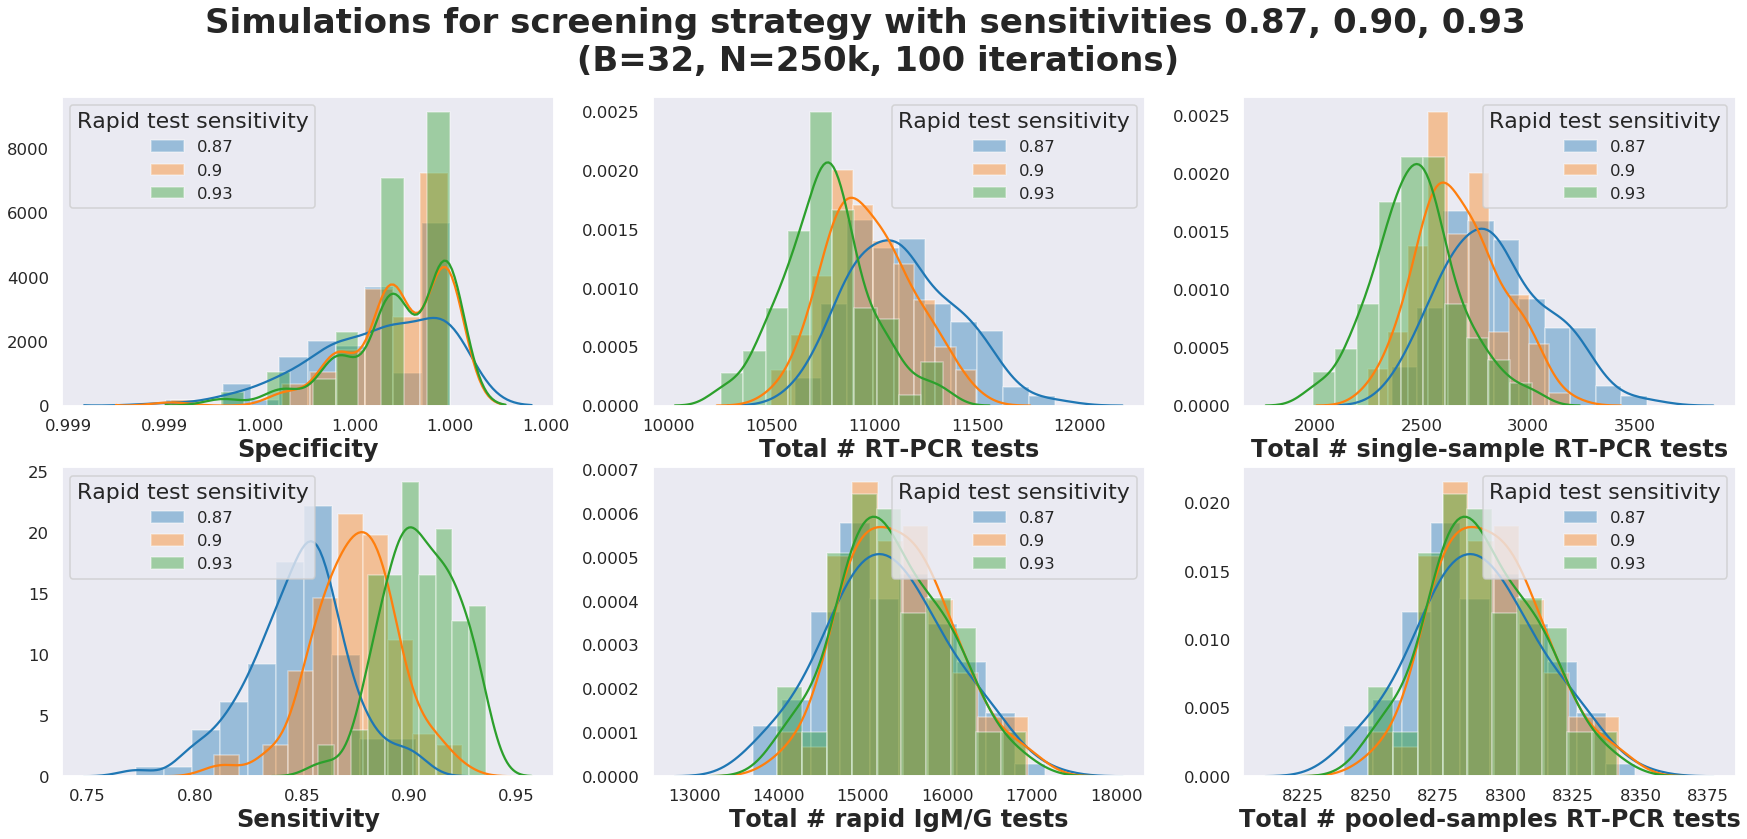

In [26]:
plots(df_s, variable='screen_sens')

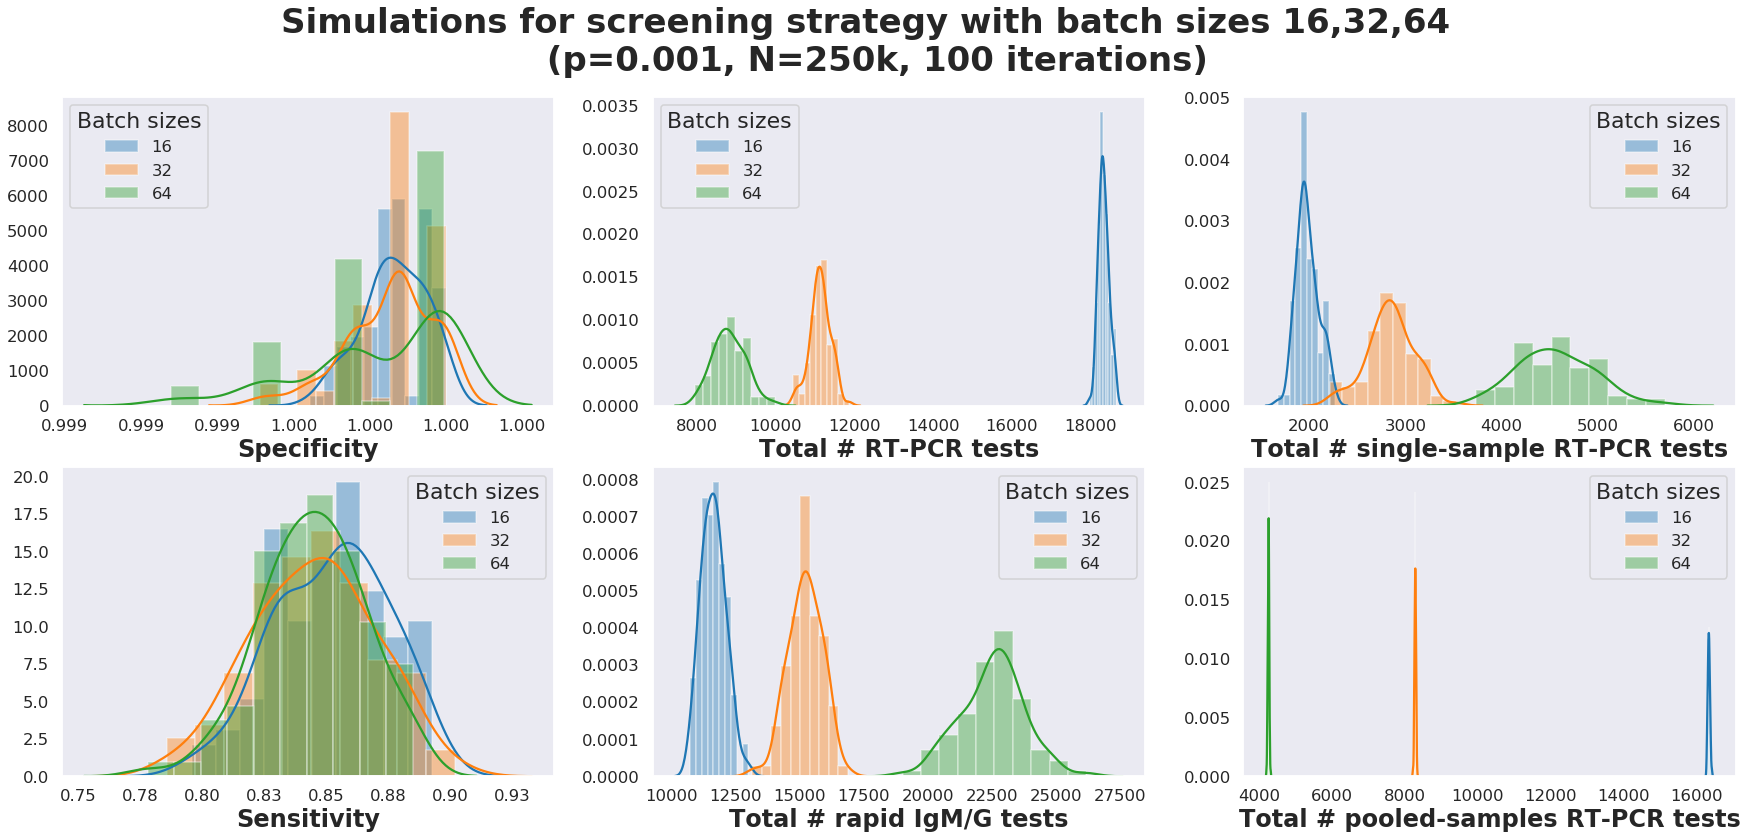

In [79]:
plots(df_b, variable='batch_size')

In [82]:
def plot_prevalence_experiment(df):
    '''
    .
    '''
    sns.set_context("talk")
    sns.set_style('dark')
    font = {'family' : 'normal',
            'weight': 'normal',
            'size'   : 22}
    plt.rc('font', **font)
    
    title = 'Simulations for screening strategy with prevalence 0.01, 0.001, 0.0001 and batches 16, 32, 64\n (N=250k, 100 iterations)'
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 12.5))
    
    for i, (name, df_g) in enumerate(df.groupby('batch_size')):
        
        axs[0][i].set_title('Batch size = {}'.format(name), fontdict={'size': 24, 'weight': 'bold'})
        plot_feature(df_g, 'total_pcrs', ax=axs[0][i], variable='prevalence', to_format=False)
        plot_feature(df_g, 'screens', ax=axs[1][i], variable='prevalence', to_format=False)

    fig.suptitle(title, fontsize=24, weight='bold')
    plt.savefig("performance_{}.jpg".format('prevalence'))
    
def plot_prevalence_experiment_1(df):
    '''
    .
    '''
    sns.set_context("talk")
    sns.set_style('dark')
    font = {'family' : 'normal',
            'weight': 'normal',
            'size'   : 22}
    plt.rc('font', **font)
    
    title = 'Simulations for screening strategy with prevalence 0.01, 0.001, 0.0001 and batches 16, 32, 64\n (N=250k, 100 iterations)'
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 12.5))
    
    for i, (name, df_g) in enumerate(df.groupby('prevalence')):
        
        axs[0][i].set_title('Prevalence = {}'.format(name), fontdict={'size': 24, 'weight': 'bold'})
        plot_feature(df_g, 'total_pcrs', ax=axs[0][i], variable='batch_size', to_format=False)
        plot_feature(df_g, 'screens', ax=axs[1][i], variable='batch_size', to_format=False)

    fig.suptitle(title, fontsize=24, weight='bold')
    plt.savefig("performance_1_{}.jpg".format('prevalence'))

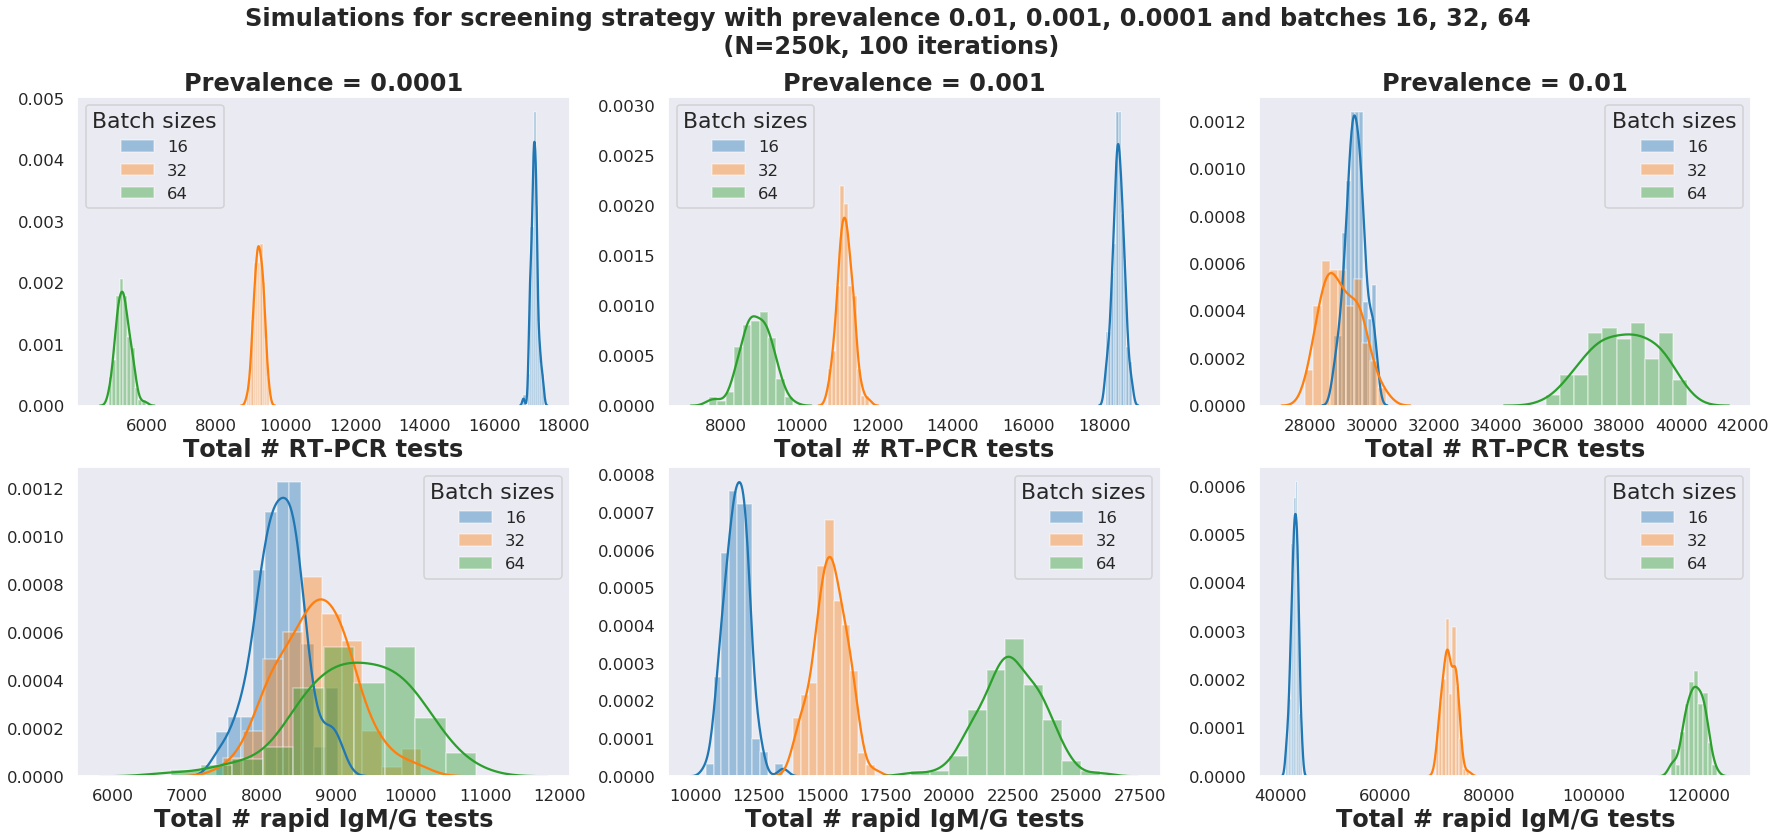

In [83]:
plot_prevalence_experiment_1(df_p)